In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from time import time
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import torch
from torch.utils.data import Dataset, TensorDataset, IterableDataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math
from utils import process_file, create_dataset
import torch.optim as optim
import torch.utils.data as data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
timeseries = process_file()

In [5]:
len(timeseries)

62

In [6]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [7]:
train.shape

(41, 1)

In [92]:
#window

lookback=1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print(X_train.shape,  y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([40, 1, 1]) torch.Size([40, 1, 1])
torch.Size([20, 1, 1]) torch.Size([20, 1, 1])


In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train = X_train.squeeze().numpy().reshape(-1, 1)
X_train = torch.tensor(scaler_x.fit_transform(X_train))

X_test = X_test.squeeze().numpy().reshape(-1, 1)
X_test = torch.tensor(scaler_x.transform(X_test))

# crear otro scaler
scaler_y = MinMaxScaler()

y_train = y_train.squeeze().numpy().reshape(-1, 1)
y_train = torch.tensor(scaler_y.fit_transform(y_train))

y_test = y_test.squeeze().numpy().reshape(-1, 1)
y_test = torch.tensor(scaler_y.transform(y_test))

In [142]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [144]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

In [145]:
X_batch.shape

torch.Size([14, 1])

In [146]:
torch.manual_seed(42)
np.random.seed(42)

train_loss = []
n_epochs = 100
print_interval = 10

print("starting")

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)

        # loss
        loss = loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f}")
    
    train_loss.append(epoch_train_loss)    
   
   # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse[-1], test_rmse[-1]))
   # print("Epoch %d: train loss %.4f, test loss %.4f" % (epoch, train_loss[-1], test_loss[-1]))


starting
Epoch 10/100, Train Loss: 0.1692
Epoch 20/100, Train Loss: 0.1593
Epoch 30/100, Train Loss: 0.1386
Epoch 40/100, Train Loss: 0.1424
Epoch 50/100, Train Loss: 0.1693
Epoch 60/100, Train Loss: 0.1195
Epoch 70/100, Train Loss: 0.1049
Epoch 80/100, Train Loss: 0.1277
Epoch 90/100, Train Loss: 0.0887
Epoch 100/100, Train Loss: 0.1092


In [147]:
X_batch.shape

torch.Size([14, 1])

In [174]:
train_preds = []
train_loss = []
test_loss = []
train_rmse = []
test_rmse = []
gradient_norm = []
test_preds = []

model.eval()

# disable gradient computation
with torch.no_grad():
        #print("eval")
        #for x in X_train:
        #y_pred_train = model(x)
        y_pred_train = model(X_train)
        y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train.detach().numpy())
        train_preds.append(y_pred_train_unscaled)          
    
        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))
    
        y_pred_test = model(X_test)
        test_preds.append(y_pred_test)
    
        test_loss.append(loss_fn(y_pred_test, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test, y_test).item()))
    

In [176]:
# creo un array concatenando las predicciones
train_array = np.concatenate([tensor.flatten() for tensor in train_preds])
test_array = np.concatenate([tensor.numpy().flatten() for tensor in test_preds])

In [177]:
len(train_array), len(test_array)

(40, 20)

In [165]:
#plt.scatter(test_array, test[:20])

In [168]:
#plt.scatter(train_array, train[:40])

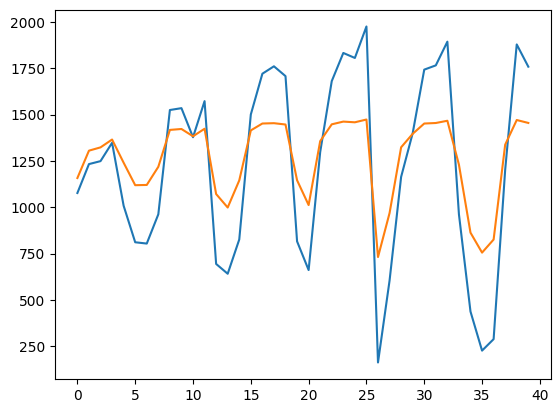

In [181]:
plt.plot(train[:40])
plt.plot(train_array)

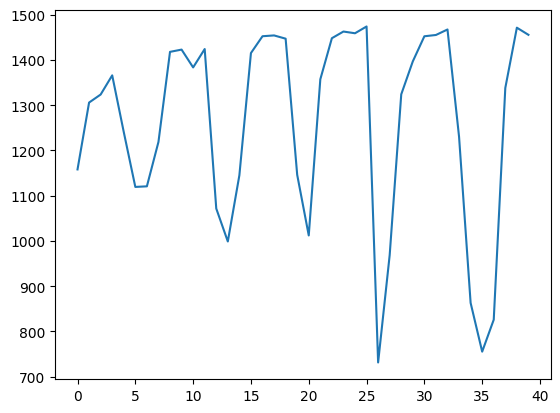

In [179]:
plt.plot(train_array)

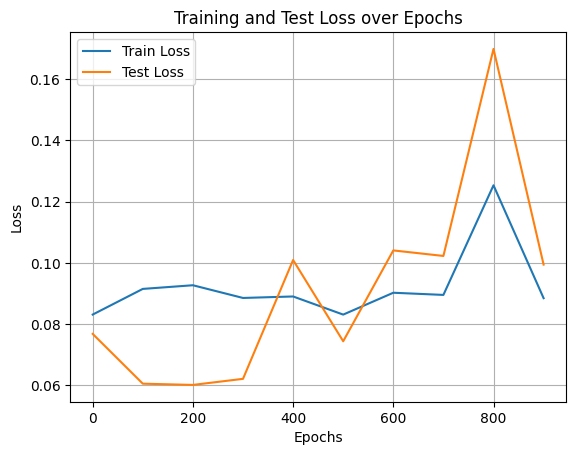

In [65]:
epochs = range(0, n_epochs, 100)

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

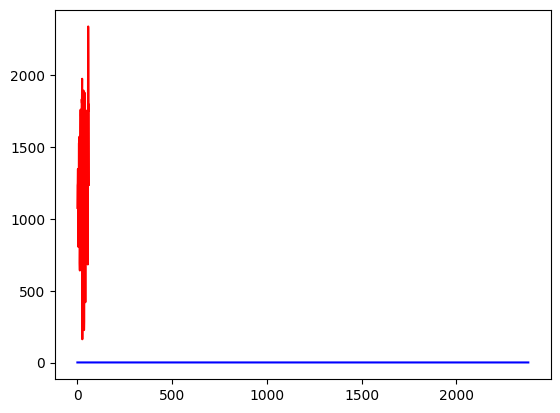

In [117]:
plt.plot(timeseries, c='r')
plt.plot(predictions_array, c='b')


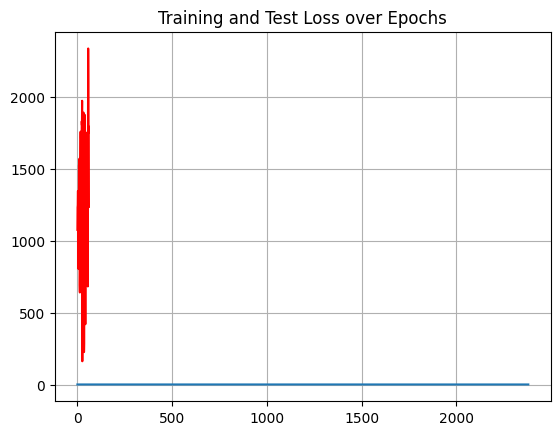

In [113]:
epochs = range(0, n_epochs, 100)

predictions_array = np.concatenate([tensor.numpy().flatten() for tensor in train_preds])
plt.plot(predictions_array, label='Train preds')
plt.plot(timeseries, c='r')

#plt.plot(epochs, test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
plt.grid(True)
plt.show()

In [50]:
with torch.no_grad():
    train_plot = np.ones_like(timeseries)  * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

In [109]:
with torch.no_grad():

# shift train predictions for plotting
    train_plot = np.ones_like(timeseries)  * np.nan

    train_plot[lookback:train_size] = predictions_array
  
    # shift test predictions for plotting
    #test_plot = np.ones_like(timeseries) * np.nan
    #test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
#plt.plot(timeseries, c='b')
#plt.plot(train_plot, c='r')
#plt.plot(test_plot, c='g')
#plt.show()

ValueError: could not broadcast input array from shape (2380,) into shape (34,1)

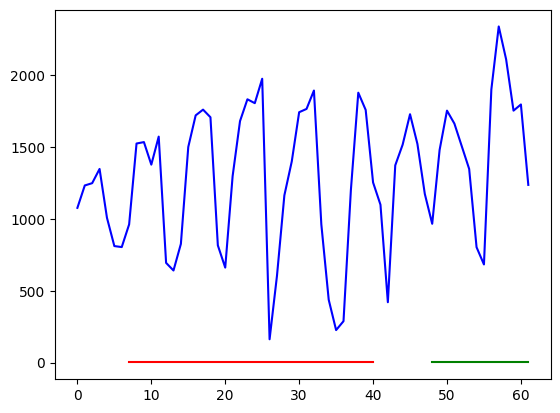

In [108]:
with torch.no_grad():

# shift train predictions for plotting
    train_plot = np.ones_like(timeseries)  * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
  
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [17]:
y_pred[:10]

tensor([[1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029],
        [1202.2029]])

In [ ]:
y